In [1]:
# Import the necessary libraries

import pandas as pd
import os
import pandas_datareader.data as pdr
from yahoo_fin.stock_info import get_dividends
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
yf.pdr_override()

In [2]:
# Initialize an empty list to hold the dataframes
dataframes = []

# Loop through all the files in the current directory, filter for CSV files that start with "ResumoNegociacao_", read them into dataframes, and append to the list
for arquivo in os.listdir():
    if arquivo.startswith("ResumoNegociacao_") and arquivo.endswith(".csv"):
        df = pd.read_csv(arquivo, sep=";")
        dataframes.append(df)

# Concatenate all the dataframes in the list into a single dataframe
carteira = pd.concat(dataframes, ignore_index=True)

#Check the dataframe
display(carteira)
carteira.info()

,Dt. Negociação,Conta,Ativo,Preço,Quantidade Compra,Quantidade Venda,Financeiro Compra,Financeiro Venda
0,14/09/2022,11100564,MXRF11,"10,2",2,0,"20,4",0
1,14/09/2022,11100564,VIVT3F,"41,51",3,0,"124,53",0
2,14/09/2022,11100564,VIVT3F,"41,51",1,0,"41,51",0
3,19/09/2022,11100564,BBSE3F,"29,84",15,0,"447,6",0
4,19/09/2022,11100564,BBSE3F,"29,88",5,0,"149,4",0
...,...,...,...,...,...,...,...,...
158,02/02/2024,11100564,RZAG11,"9,00",50,0,"450,00","0,00"
159,19/02/2024,11100564,TAEE11F,"35,50",10,0,"355,00","0,00"
160,20/02/2024,11100564,BBSE3F,"32,60",15,0,"489,00","0,00"
161,21/02/2024,11100564,TAEE11F,"35,00",10,0,"350,00","0,00"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Dt. Negociação     163 non-null    object
 1   Conta              163 non-null    int64 
 2   Ativo              163 non-null    object
 3   Preço              163 non-null    object
 4   Quantidade Compra  163 non-null    int64 
 5   Quantidade Venda   163 non-null    int64 
 6   Financeiro Compra  163 non-null    object
 7   Financeiro Venda   163 non-null    object
dtypes: int64(3), object(5)
memory usage: 10.3+ KB


In [3]:
# Remove columns that are not useful for the analysis
carteira = carteira.drop(["Conta", "Preço"], axis=1)

# Converting columns to numeric type
carteira['Financeiro Compra'] = pd.to_numeric(carteira['Financeiro Compra'].str.replace('.', '').str.replace(',', '.'))
carteira['Financeiro Venda'] = pd.to_numeric(carteira['Financeiro Venda'].str.replace('.', '').str.replace(',', '.'))

# Convert the 'Dt. Negociação' column to datetime format
carteira['Dt. Negociação'] = pd.to_datetime(carteira['Dt. Negociação'], format='%d/%m/%Y')


display(carteira)

,Dt. Negociação,Ativo,Quantidade Compra,Quantidade Venda,Financeiro Compra,Financeiro Venda
0,2022-09-14,MXRF11,2,0,20.40,NaN
1,2022-09-14,VIVT3F,3,0,124.53,NaN
2,2022-09-14,VIVT3F,1,0,41.51,NaN
3,2022-09-19,BBSE3F,15,0,447.60,NaN
4,2022-09-19,BBSE3F,5,0,149.40,NaN
...,...,...,...,...,...,...
158,2024-02-02,RZAG11,50,0,450.00,0.0
159,2024-02-19,TAEE11F,10,0,355.00,0.0
160,2024-02-20,BBSE3F,15,0,489.00,0.0
161,2024-02-21,TAEE11F,10,0,350.00,0.0


In [4]:
#Fill NaN
carteira = carteira.fillna(0.00)
display(carteira)

,Dt. Negociação,Ativo,Quantidade Compra,Quantidade Venda,Financeiro Compra,Financeiro Venda
0,2022-09-14,MXRF11,2,0,20.40,0.0
1,2022-09-14,VIVT3F,3,0,124.53,0.0
2,2022-09-14,VIVT3F,1,0,41.51,0.0
3,2022-09-19,BBSE3F,15,0,447.60,0.0
4,2022-09-19,BBSE3F,5,0,149.40,0.0
...,...,...,...,...,...,...
158,2024-02-02,RZAG11,50,0,450.00,0.0
159,2024-02-19,TAEE11F,10,0,355.00,0.0
160,2024-02-20,BBSE3F,15,0,489.00,0.0
161,2024-02-21,TAEE11F,10,0,350.00,0.0


In [5]:
# Group by date and stock, then aggregate the sum for specified columns to reduce redundant entries
carteira = carteira.groupby(['Dt. Negociação', 'Ativo'], as_index=False).agg({
    'Quantidade Compra': 'sum',
    'Quantidade Venda': 'sum',
    'Financeiro Compra': 'sum',
    'Financeiro Venda': 'sum'
    })

# Remove rows where the 'Ativo' column has specific values, those stocks are not useful for the analysis
carteira = carteira.drop(carteira[carteira["Ativo"] == "ITSA10F"].index)
carteira = carteira.drop(carteira[carteira["Ativo"] == "NUBR33"].index)
carteira = carteira.drop(carteira[carteira["Ativo"] == "ITSA4F"].index)
carteira.reset_index(inplace=True, drop=True)

#multiplication made due to share split
carteira.loc[carteira['Ativo'] == 'BBAS3F', 'Quantidade Compra'] *= 2
carteira.loc[carteira['Ativo'] == 'BBAS3F', 'Quantidade Venda'] *= 2
carteira.loc[carteira['Ativo'] == 'SNAG11', 'Quantidade Compra'] *= 10
carteira.loc[carteira['Ativo'] == 'SNAG11', 'Quantidade Venda'] *= 10


# Standardize a specific stock ticker in the 'Ativo' column
carteira.loc[carteira['Ativo'] == 'KLBN4F', 'Ativo'] = 'KLBN4'

display(carteira)

,Dt. Negociação,Ativo,Quantidade Compra,Quantidade Venda,Financeiro Compra,Financeiro Venda
0,2022-09-14,MXRF11,2,0,20.40,0.0
1,2022-09-14,VIVT3F,4,0,166.04,0.0
2,2022-09-19,BBSE3F,20,0,597.00,0.0
3,2022-09-19,MXRF11,8,0,82.32,0.0
4,2022-09-19,TAEE11F,20,0,819.40,0.0
...,...,...,...,...,...,...
109,2024-02-02,RZAG11,50,0,450.00,0.0
110,2024-02-19,TAEE11F,10,0,355.00,0.0
111,2024-02-20,BBSE3F,15,0,489.00,0.0
112,2024-02-21,TAEE11F,10,0,350.00,0.0


In [6]:
# Create a new dataframe by grouping the Stock and adding the amount spent on buying or selling
carteira_por_acao = carteira.groupby(['Ativo'], as_index=False).agg({
    'Quantidade Compra': 'sum',
    'Quantidade Venda': 'sum',
    'Financeiro Compra': 'sum',
    'Financeiro Venda': 'sum'
    })

display(carteira_por_acao)

,Ativo,Quantidade Compra,Quantidade Venda,Financeiro Compra,Financeiro Venda
0,AESB3F,80,0,903.00,0.00
1,B3SA3F,87,14,1015.40,194.18
2,BBAS3F,50,26,1004.73,657.15
3,BBDC3F,50,50,615.00,715.00
4,BBSE3F,60,0,1857.50,0.00
5,BTAL11,15,0,1273.14,0.00
6,BTLG11,10,0,1018.51,0.00
7,CXSE3F,60,0,631.50,0.00
8,FAED11,4,4,595.81,592.04
9,HGLG11,5,0,798.45,0.00


In [7]:
# Calculate profit or loss for fully transacted stocks and remove these transactions from the dataframe.
lucro_prejuizo = 0

for index, row in carteira_por_acao.iterrows():
    if row['Quantidade Compra'] == row['Quantidade Venda']:
        lucro_prejuizo_acao = row['Financeiro Venda'] - row['Financeiro Compra']
        lucro_prejuizo += lucro_prejuizo_acao
        carteira_por_acao = carteira_por_acao.drop(index)

carteira_por_acao.reset_index(inplace=True, drop=True)
print(lucro_prejuizo)

# Update the dataframe to reflect remaining quantities and financials, and drop the redundant columns
carteira_por_acao['Quantidade'] = 0
carteira_por_acao['Financeiro'] = 0

for i in range(len(carteira_por_acao)):
    if carteira_por_acao.at[i,'Quantidade Venda'] == 0:
        carteira_por_acao.at[i, 'Quantidade'] = carteira_por_acao.at[i, 'Quantidade Compra']
        carteira_por_acao.at[i, 'Financeiro'] = carteira_por_acao.at[i, 'Financeiro Compra']
        carteira_por_acao.at[i, 'Preço'] = carteira_por_acao.at[i, 'Financeiro'] / carteira_por_acao.at[i, 'Quantidade']
    else:
        carteira_por_acao.at[i, 'Quantidade'] = carteira_por_acao.at[i, 'Quantidade Compra'] - carteira_por_acao.at[i, 'Quantidade Venda']
        carteira_por_acao.at[i, 'Financeiro'] = carteira_por_acao.at[i, 'Financeiro Compra'] - carteira_por_acao.at[i, 'Financeiro Venda']
        carteira_por_acao.at[i, 'Preço'] = carteira_por_acao.at[i, 'Financeiro'] / carteira_por_acao.at[i, 'Quantidade']

carteira_por_acao = carteira_por_acao.drop(['Quantidade Compra','Quantidade Venda','Financeiro Compra','Financeiro Venda'], axis=1)
display(carteira_por_acao)



413.87


,Ativo,Quantidade,Financeiro,Preço
0,AESB3F,80,903.00,11.287500
1,B3SA3F,73,821.22,11.249589
2,BBAS3F,24,347.58,14.482500
3,BBSE3F,60,1857.50,30.958333
4,BTAL11,15,1273.14,84.876000
5,BTLG11,10,1018.51,101.851000
6,CXSE3F,60,631.50,10.525000
7,HGLG11,5,798.45,159.690000
8,KLBN4,150,636.18,4.241200
9,KNCR11,8,791.00,98.875000


In [8]:
# Add a new column to track the total invested amount, considering both purchases and sales, and calculate a running total
carteira['Total investido'] = 0

for i in range(len(carteira)):
    if carteira.iloc[i]['Financeiro Compra'] > 0:
        carteira.at[carteira.index[i], 'Total investido'] = carteira.iloc[i]['Financeiro Compra']
    else:
        carteira.at[carteira.index[i], 'Total investido'] = -carteira.iloc[i]['Financeiro Venda']

for i in range(1, len(carteira)):
    carteira.at[carteira.index[i], 'Total investido'] += carteira.at[carteira.index[i - 1], 'Total investido']


display(carteira)


,Dt. Negociação,Ativo,Quantidade Compra,Quantidade Venda,Financeiro Compra,Financeiro Venda,Total investido
0,2022-09-14,MXRF11,2,0,20.40,0.0,20.40
1,2022-09-14,VIVT3F,4,0,166.04,0.0,186.44
2,2022-09-19,BBSE3F,20,0,597.00,0.0,783.44
3,2022-09-19,MXRF11,8,0,82.32,0.0,865.76
4,2022-09-19,TAEE11F,20,0,819.40,0.0,1685.16
...,...,...,...,...,...,...,...
109,2024-02-02,RZAG11,50,0,450.00,0.0,14991.19
110,2024-02-19,TAEE11F,10,0,355.00,0.0,15346.19
111,2024-02-20,BBSE3F,15,0,489.00,0.0,15835.19
112,2024-02-21,TAEE11F,10,0,350.00,0.0,16185.19


In [9]:
#real proof

total_investido = carteira_por_acao.Financeiro.sum() - lucro_prejuizo
print(total_investido)

17046.59


In [10]:
# Define and apply a function to modify stock tickers to match the yfinance format for both dataframes
def modificar_ativo(ativo):
    if ativo.endswith('F'):
        return ativo[:-1] + '.SA'  # Remove the 'F' and add '.SA'
    else:
        return ativo + '.SA'


carteira_por_acao['Ativo'] = carteira_por_acao['Ativo'].apply(modificar_ativo)
carteira['Ativo'] = carteira['Ativo'].apply(modificar_ativo)


display(carteira_por_acao)
display(carteira)

,Ativo,Quantidade,Financeiro,Preço
0,AESB3.SA,80,903.00,11.287500
1,B3SA3.SA,73,821.22,11.249589
2,BBAS3.SA,24,347.58,14.482500
3,BBSE3.SA,60,1857.50,30.958333
4,BTAL11.SA,15,1273.14,84.876000
5,BTLG11.SA,10,1018.51,101.851000
6,CXSE3.SA,60,631.50,10.525000
7,HGLG11.SA,5,798.45,159.690000
8,KLBN4.SA,150,636.18,4.241200
9,KNCR11.SA,8,791.00,98.875000


,Dt. Negociação,Ativo,Quantidade Compra,Quantidade Venda,Financeiro Compra,Financeiro Venda,Total investido
0,2022-09-14,MXRF11.SA,2,0,20.40,0.0,20.40
1,2022-09-14,VIVT3.SA,4,0,166.04,0.0,186.44
2,2022-09-19,BBSE3.SA,20,0,597.00,0.0,783.44
3,2022-09-19,MXRF11.SA,8,0,82.32,0.0,865.76
4,2022-09-19,TAEE11.SA,20,0,819.40,0.0,1685.16
...,...,...,...,...,...,...,...
109,2024-02-02,RZAG11.SA,50,0,450.00,0.0,14991.19
110,2024-02-19,TAEE11.SA,10,0,355.00,0.0,15346.19
111,2024-02-20,BBSE3.SA,15,0,489.00,0.0,15835.19
112,2024-02-21,TAEE11.SA,10,0,350.00,0.0,16185.19


# Now that I have a dataframe treated with transactions and one that represents my current portfolio, let's import the quotes


In [11]:
# Generate a list of unique stock tickers from the 'Ativo' column and get dates

lista_acoes = list(set(carteira['Ativo']))
data_final = datetime.now()
data_final = data_final.strftime('%Y-%m-%d')
data_inicial = carteira['Dt. Negociação'][0]
data_inicial = data_inicial.strftime('%Y-%m-%d')

# Fetch historical closing prices for the list of stocks from Yahoo Finance
tabela_cotacoes = pdr.get_data_yahoo(lista_acoes, data_inicial, data_final)['Close']

# Forward fill any missing data to ensure there are no gaps in the stock price data
tabela_cotacoes.ffill(inplace=True)
tabela_cotacoes



[*********************100%%**********************]  25 of 25 completed


Ticker,AESB3.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBSE3.SA,BTAL11.SA,BTLG11.SA,CXSE3.SA,FAED11.SA,HGLG11.SA,...,MXRF11.SA,NEOE3.SA,PETR4.SA,RZAG11.SA,SNAG11.SA,TAEE11.SA,URPR11.SA,VALE3.SA,VIVT3.SA,XPPR11.SA
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-14,9.768726,12.78,20.129999,15.910000,28.120001,101.300003,102.791061,8.900000,151.444397,165.091003,...,10.058241,16.450001,31.120001,10.34,10.085,41.080002,102.989998,67.000000,41.369999,46.880001
2022-09-15,9.648741,12.56,19.924999,15.840000,28.330000,102.199997,102.988907,8.960000,153.336212,164.844131,...,10.038519,16.459999,31.059999,10.35,10.070,40.840000,103.070000,68.349998,41.279999,46.549999
2022-09-16,9.758727,12.38,19.700001,15.680000,29.469999,101.470001,102.791061,8.630000,152.141388,171.815506,...,10.156851,16.309999,30.780001,10.38,10.029,40.650002,102.949997,68.250000,40.630001,45.959999
2022-09-19,9.668739,13.22,20.090000,16.059999,29.809999,102.339996,102.543755,9.000000,154.321945,170.354080,...,10.156851,16.280001,31.270000,10.40,10.030,40.939999,102.910004,70.459999,40.990002,46.290001
2022-09-20,9.608746,13.64,20.395000,16.650000,30.219999,102.400002,102.820740,9.100000,153.644882,170.926804,...,10.107546,16.000000,31.090000,10.10,10.035,41.299999,102.989998,69.449997,41.049999,45.520000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-08,9.530000,11.67,28.379999,12.280000,32.619999,69.220001,102.879997,16.600000,153.460007,165.729996,...,10.320000,19.400000,41.270000,8.36,10.050,35.650002,84.019997,63.990002,46.939999,20.400000
2024-05-09,9.500000,11.21,27.139999,11.960000,32.619999,69.489998,102.410004,16.209999,153.000000,164.470001,...,10.330000,19.299999,41.669998,8.36,10.030,34.810001,84.300003,64.510002,45.529999,19.930000
2024-05-10,9.590000,10.94,27.620001,11.950000,33.130001,69.910004,102.699997,16.080000,153.529999,164.309998,...,10.330000,19.200001,41.580002,8.44,10.040,34.619999,84.389999,64.290001,45.110001,19.700001


In [12]:
# Fetch historical closing prices for the IBOVESPA index from Yahoo Finance and convert it to a DataFrame
df_ibov = pdr.get_data_yahoo('^BVSP', data_inicial, data_final)['Close']
df_ibov = df_ibov.to_frame(name='ibov')

# Update the final date to the last available date in the fetched stock prices data
data_final = tabela_cotacoes.index[-1]
data_final = data_final.strftime('%Y-%m-%d')

[*********************100%%**********************]  1 of 1 completed


In [13]:
# Initialize a DataFrame to store the portfolio values over time, indexed by dates
df_carteira_valor = pd.DataFrame(tabela_cotacoes.index).set_index('Date')

# Initialize columns for each stock in the portfolio with zeros
for dia in df_carteira_valor.index:
    for ativo in carteira['Ativo']:
        df_carteira_valor[ativo] = 0

# Populate the DataFrame with the financial values for each transaction date        
for indice, linha in carteira.iterrows():
    quant_compra = linha['Financeiro Compra']
    quant_venda = linha['Financeiro Venda']
    if quant_compra != 0:   
        df_carteira_valor.loc[linha['Dt. Negociação'], linha['Ativo']] = quant_compra
    else:
        df_carteira_valor.loc[linha['Dt. Negociação'], linha['Ativo']] -= quant_venda


# Update the DataFrame to maintain cumulative totals for each stock over time
for indice in df_carteira_valor.index[1:]:
    for coluna in df_carteira_valor.columns:
        if df_carteira_valor.loc[indice, coluna] != 0:
            df_carteira_valor.loc[indice, coluna] += df_carteira_valor.shift(1).loc[indice, coluna]
        else:
            df_carteira_valor.loc[indice, coluna] = df_carteira_valor.shift(1).loc[indice, coluna]

# Sort the DataFrame columns alphabetically and calculate the total invested value for each date
df_carteira_valor = df_carteira_valor.sort_index(axis=1)
df_carteira_valor['Total investido'] = df_carteira_valor.sum(axis=1)

# Display the final DataFrame with cumulative portfolio values and total invested
display(df_carteira_valor)

,AESB3.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBSE3.SA,BTAL11.SA,BTLG11.SA,CXSE3.SA,FAED11.SA,HGLG11.SA,...,NEOE3.SA,PETR4.SA,RZAG11.SA,SNAG11.SA,TAEE11.SA,URPR11.SA,VALE3.SA,VIVT3.SA,XPPR11.SA,Total investido
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-14,0,0.00,0.00,0,0.0,0.00,0.00,0.0,0.00,0.00,...,0.0,0.0,0.0,0.00,0.0,0.00,0.00,166.04,0,186.44
2022-09-15,0,0.00,0.00,0,0.0,0.00,0.00,0.0,0.00,0.00,...,0.0,0.0,0.0,0.00,0.0,0.00,0.00,166.04,0,186.44
2022-09-16,0,0.00,0.00,0,0.0,0.00,0.00,0.0,0.00,0.00,...,0.0,0.0,0.0,0.00,0.0,0.00,0.00,166.04,0,186.44
2022-09-19,0,0.00,0.00,0,597.0,0.00,0.00,0.0,0.00,0.00,...,0.0,0.0,0.0,0.00,819.4,0.00,0.00,166.04,0,1685.16
2022-09-20,0,0.00,0.00,0,597.0,0.00,0.00,0.0,0.00,0.00,...,0.0,0.0,0.0,0.00,819.4,0.00,0.00,166.04,0,1685.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-08,903,821.22,347.58,-100,1857.5,1273.14,1018.51,631.5,3.77,798.45,...,374.7,-153.3,824.1,1312.05,2139.9,956.12,1878.11,-230.52,213,17046.59
2024-05-09,903,821.22,347.58,-100,1857.5,1273.14,1018.51,631.5,3.77,798.45,...,374.7,-153.3,824.1,1312.05,2139.9,956.12,1878.11,-230.52,213,17046.59
2024-05-10,903,821.22,347.58,-100,1857.5,1273.14,1018.51,631.5,3.77,798.45,...,374.7,-153.3,824.1,1312.05,2139.9,956.12,1878.11,-230.52,213,17046.59


In [14]:
# Initialize a DataFrame to store the quantity of stocks over time, indexed by dates
df_carteira = pd.DataFrame(tabela_cotacoes.index).set_index('Date')

# Initialize columns for each stock in the portfolio with zeros
for dia in df_carteira.index:
    for ativo in carteira['Ativo']:
        df_carteira[ativo] = 0

# Populate the DataFrame with the quantity of stocks for each transaction date   
for indice, linha in carteira.iterrows():
    quant_compra = linha['Quantidade Compra']
    quant_venda = linha['Quantidade Venda']
    if quant_compra != 0:   
        df_carteira.loc[linha['Dt. Negociação'], linha['Ativo']] = quant_compra
    else:
        df_carteira.loc[linha['Dt. Negociação'], linha['Ativo']] -= quant_venda

# Update the DataFrame to maintain cumulative totals for each stock over time
for indice in df_carteira.index[1:]:
    for coluna in df_carteira.columns:
        if df_carteira.loc[indice, coluna] != 0:
            df_carteira.loc[indice, coluna] += df_carteira.shift(1).loc[indice, coluna]
        else:
            df_carteira.loc[indice, coluna] = df_carteira.shift(1).loc[indice, coluna]
             
# Sort the DataFrame columns alphabetically for better organization
df_carteira = df_carteira.sort_index(axis=1)
display(df_carteira)

,AESB3.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBSE3.SA,BTAL11.SA,BTLG11.SA,CXSE3.SA,FAED11.SA,HGLG11.SA,...,MXRF11.SA,NEOE3.SA,PETR4.SA,RZAG11.SA,SNAG11.SA,TAEE11.SA,URPR11.SA,VALE3.SA,VIVT3.SA,XPPR11.SA
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-14,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,4,0
2022-09-15,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,4,0
2022-09-16,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,4,0
2022-09-19,0,0,0,0,20,0,0,0,0,0,...,10,0,0,0,0,20,0,0,4,0
2022-09-20,0,0,0,0,20,0,0,0,0,0,...,10,0,0,0,0,20,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-08,80,73,24,0,60,15,10,60,0,5,...,29,30,0,90,130,58,10,30,0,0
2024-05-09,80,73,24,0,60,15,10,60,0,5,...,29,30,0,90,130,58,10,30,0,0
2024-05-10,80,73,24,0,60,15,10,60,0,5,...,29,30,0,90,130,58,10,30,0,0


In [15]:
# Calculate the current value of the portfolio by multiplying the quantity of each stock by its current price
df_carteira_valor_atual = df_carteira * tabela_cotacoes

# Calculate the total current value of the portfolio by summing the values across all stocks for each date
df_carteira_valor_atual['Total atual'] = df_carteira_valor_atual.sum(axis=1)

# Display the DataFrame with the current portfolio values
display(df_carteira_valor_atual)

,AESB3.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBSE3.SA,BTAL11.SA,BTLG11.SA,CXSE3.SA,FAED11.SA,HGLG11.SA,...,NEOE3.SA,PETR4.SA,RZAG11.SA,SNAG11.SA,TAEE11.SA,URPR11.SA,VALE3.SA,VIVT3.SA,XPPR11.SA,Total atual
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-14,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,165.479996,0.0,185.596478
2022-09-15,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,165.119995,0.0,185.197033
2022-09-16,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,162.520004,0.0,182.833706
2022-09-19,0.000000,0.000000,0.000000,0.0,596.199989,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,818.799973,0.000000,0.000000,163.960007,0.0,1680.528477
2022-09-20,0.000000,0.000000,0.000000,0.0,604.399986,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,825.999985,0.000000,0.000000,164.199997,0.0,1695.675426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-08,762.399979,851.910006,681.119980,0.0,1957.199936,1038.300018,1028.799973,996.000023,0.0,828.649979,...,581.999989,0.0,752.399969,1306.500025,2067.700089,840.199966,1919.700050,0.000000,0.0,17849.719986
2024-05-09,760.000000,818.330003,651.359985,0.0,1957.199936,1042.349968,1024.100037,972.599945,0.0,822.350006,...,578.999977,0.0,752.399969,1303.899965,2018.980080,843.000031,1935.300064,0.000000,0.0,17713.819954
2024-05-10,767.200012,798.619969,662.880020,0.0,1987.800064,1048.650055,1026.999969,964.799995,0.0,821.549988,...,576.000023,0.0,759.599962,1305.199995,2007.959938,843.899994,1928.700027,0.000000,0.0,17729.529972


In [16]:
# Combine the 'Total investido' and 'Total atual' columns into a new DataFrame for normalization and analysis
total_norm = pd.concat([df_carteira_valor['Total investido'], df_carteira_valor_atual['Total atual']], axis=1)

# Calculate profit/loss as a ratio of 'Total atual' to 'Total investido'
total_norm[r'Lucro/preju'] = total_norm['Total atual'] / total_norm['Total investido']

# Normalize the IBOVESPA index values relative to the first entry
df_ibov['ibov norm'] = df_ibov / df_ibov.iloc[0]

# Initialize a new column for cumulative dividends in the 'total_norm' DataFrame
total_norm['dividendo'] = 0.0

# Initialize a variable to hold the total value of dividends
valor_total = 0

# Create a dictionary to store dividend data for each stock
dividendos_dic = {}

# Fetch and process dividend data for each stock in the portfolio
for ativo in lista_acoes:
    dividendos_dic[ativo] = get_dividends(ativo, start_date=data_inicial)
    dividendos_dic[ativo].index.name = 'Date'
    dividendos_dic[ativo].rename(columns={'ticker': 'Ativo'}, inplace=True)
    for indice, linha in dividendos_dic[ativo].iterrows():
        valor = dividendos_dic[ativo].at[indice, 'dividend'] * df_carteira.at[indice, linha['Ativo']]
        total_norm.loc[indice, 'dividendo'] += valor

# Update the 'dividendo' column to maintain cumulative totals over time
for indice in total_norm.index[1:]:
    if total_norm.loc[indice, 'dividendo'] != 0:
        total_norm.loc[indice, 'dividendo'] += total_norm.shift(1).loc[indice, 'dividendo']
    else:
        total_norm.loc[indice, 'dividendo'] = total_norm.shift(1).loc[indice, 'dividendo']

# Calculate the total current value including dividends
total_norm['Total atual com div'] = total_norm['Total atual'] + total_norm['dividendo']

# Calculate normalized profit/loss including dividends
total_norm['Lucro_div_norm'] = total_norm['Total atual com div'] / total_norm['Total investido']

# Display the final DataFrame with all calculations
display(total_norm)


C:\Users\graco\anaconda3\Lib\site-packages\yahoo_fin\stock_info.py:693: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  frame.index = pd.to_datetime(frame.index, unit = "s")
C:\Users\graco\anaconda3\Lib\site-packages\yahoo_fin\stock_info.py:693: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  frame.index = pd.to_datetime(frame.index, unit = "s")
C:\Users\graco\anaconda3\Lib\site-packages\yahoo_fin\stock_info.py:693: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing 

C:\Users\graco\anaconda3\Lib\site-packages\yahoo_fin\stock_info.py:693: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  frame.index = pd.to_datetime(frame.index, unit = "s")
C:\Users\graco\anaconda3\Lib\site-packages\yahoo_fin\stock_info.py:693: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  frame.index = pd.to_datetime(frame.index, unit = "s")
C:\Users\graco\anaconda3\Lib\site-packages\yahoo_fin\stock_info.py:693: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing 

,Total investido,Total atual,Lucro/preju,dividendo,Total atual com div,Lucro_div_norm
Date,,,,,,
2022-09-14,186.44,185.596478,0.995476,0.000000,185.596478,0.995476
2022-09-15,186.44,185.197033,0.993333,0.000000,185.197033,0.993333
2022-09-16,186.44,182.833706,0.980657,0.000000,182.833706,0.980657
2022-09-19,1685.16,1680.528477,0.997252,0.000000,1680.528477,0.997252
2022-09-20,1685.16,1695.675426,1.006240,0.000000,1695.675426,1.006240
...,...,...,...,...,...,...
2024-05-08,17046.59,17849.719986,1.047114,2101.799171,19951.519157,1.170411
2024-05-09,17046.59,17713.819954,1.039142,2101.799171,19815.619125,1.162439
2024-05-10,17046.59,17729.529972,1.040063,2101.799171,19831.329143,1.163360


In [ ]:
# Export dataframes to CSV files for use in Power BI

carteira.to_csv('carteira.csv', sep=";")
carteira_por_acao.to_csv('carteira_por_acao.csv', sep=";")
tabela_cotacoes.to_csv('tabela_cotacoes.csv', sep=";")
df_carteira_valor.to_csv('df_carteira_valor.csv', sep=";")
df_carteira.to_csv('df_carteira.csv', sep=";")
df_carteira_valor_atual.to_csv('df_carteira_valor_atual.csv', sep=";")
total_norm.to_csv('total_norm.csv', sep=";")
df_ibov.to_csv('df_ibov.csv', sep=";")

for key, df in dividendos_dic.items():
    df.to_csv(f'{key}.csv', sep=";")

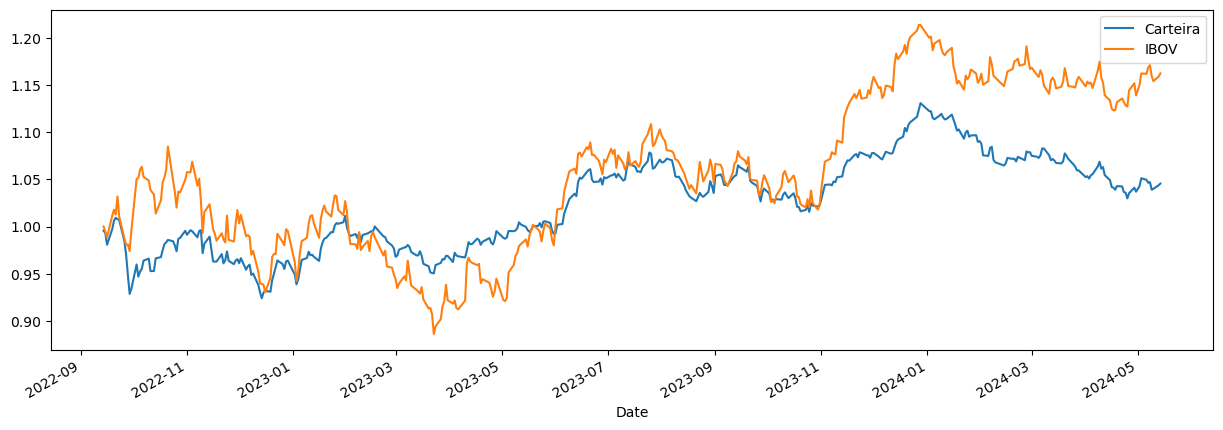

O ibov subiu 16.25%
A carteira subiu 4.56%


In [17]:
#A quick analysis between Ibovespa and the portfolio

total_norm['Lucro/preju'].plot(label='Carteira', figsize=(15,5))
df_ibov['ibov norm'].plot(label='IBOV')
plt.legend()
plt.show()

print(f"O ibov subiu {(df_ibov['ibov norm'][-1] - 1):.2%}")
print(f"A carteira subiu {(total_norm[r'Lucro/preju'][-1] - 1):.2%}")

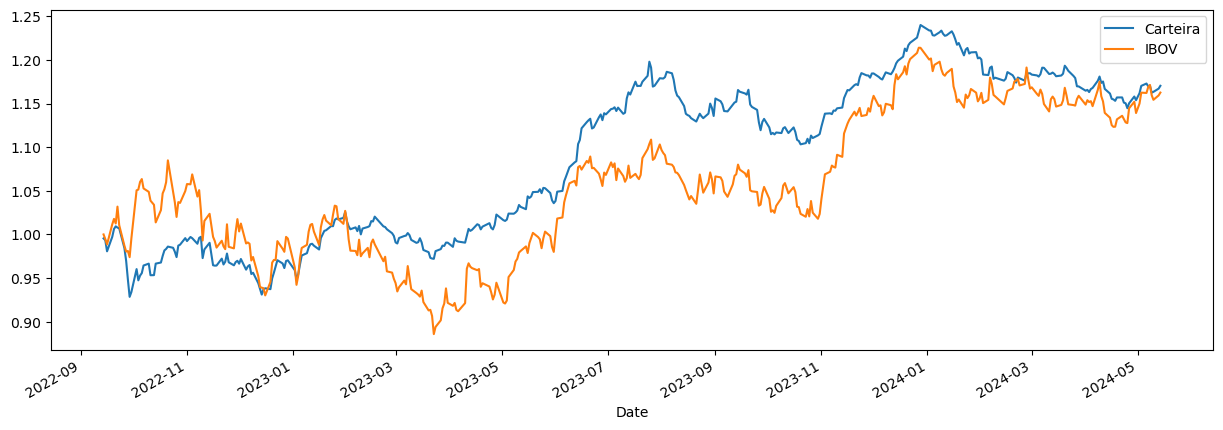

O ibov subiu 16.25%
A carteira com dividendos subiu 17.03%


In [18]:
#A quick analysis between Ibovespa and the portfolio + dividends

total_norm['Lucro_div_norm'].plot(label='Carteira', figsize=(15,5))
df_ibov['ibov norm'].plot(label='IBOV')
plt.legend()
plt.show()

print(f"O ibov subiu {(df_ibov['ibov norm'][-1] - 1):.2%}")
print(f"A carteira com dividendos subiu {(total_norm[r'Lucro_div_norm'][-1] - 1):.2%}")




In [ ]:
# Function to calculate and display dividends for a given stock
def Dividendos(ativo):
    div = get_dividends(ativo, start_date=data_inicial)
    div['quantidade'] = 0
    div['total'] = 0
    valortotal = 0
    for indice, linha in div.iterrows():
        valor = div.at[indice, 'dividend'] * df_carteira.at[indice,ativo]
        div.at[indice,'quantidade'] = df_carteira.at[indice,ativo]
        div.at[indice,'total'] = valor
        valortotal += valor
    
    display(div.loc[div['total'] > 0])
    print(f'Você recebeu no total R${valortotal:.2f} de dividendos')

    
# Function to analyze a specific stock in the portfolio
def AnalizarAtivo():
    ativo = str(input('Escolha um Ativo:'))
    if ativo in carteira_por_acao['Ativo'].values:
        quant = carteira_por_acao.loc[carteira_por_acao['Ativo']==ativo,'Quantidade'].values[0]
        preço_medio = carteira_por_acao.loc[carteira_por_acao['Ativo']==ativo,'Preço'].values[0]
        preço_atual = tabela_cotacoes.loc[data_final,ativo]
        porce_carteira = (df_carteira_valor_atual.loc[data_final,ativo] * 100) / df_carteira_valor_atual.loc[data_final,'Total atual']
        print(f'Você possui {quant} ações')
        print(f'O seu preço médio é de R${preço_medio:.2f}')
        print(f'Valor da ação no dia {data_final} é de R${preço_atual:.2f}')
        print(f'Lucro/prejuizo de {((preço_atual/preço_medio) -1):.2%}')
        print(f"Porcentagem na carteira é de {porce_carteira:.2f}%")
        tabela_cotacoes[ativo].plot(label=ativo, figsize=(15,5))
        plt.legend()
        plt.show()
        Dividendos(ativo)
    else:
        print('Você não possui esse ativo na carteira')

